In [8]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
import pickle
from meep_material import lorentzfit
import os

In [9]:
import numpy as np
import meep as mp
import nlopt
from typing import Tuple

# lorentzfit 함수는 이미 정의되어 있어야 함 (여기선 너가 가지고 있다고 가정함)

def fit_material_from_csv(
    csv_path: str,
    wl_range_nm = [0.38, 0.72],
    eps_inf: float = 1.1,
    num_lorentzians: int = 3,
    num_repeat: int = 100,
    opt_tol: float = 1e-25,
    maxeval: int = 50000,
) -> mp.Medium:
    # --- 0) 피클 경로 설정 ---
    base, _ = os.path.splitext(csv_path)
    pickle_path = base + "_fit.pkl"

    # --- 1) 피클이 있으면 로드 후 반환 ---
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            eps_inf, E_sus, freq_range = pickle.load(f)
        print(f"Loaded fit from pickle: {pickle_path}")
        return eps_inf, E_sus, freq_range
    
    # 데이터 불러오기
    mydata = np.genfromtxt(csv_path, delimiter=",")
    wl = mydata[:, 0]  # um
    n_complex = mydata[:, 1] + 1j * mydata[:, 2]
    eps_data = np.square(n_complex) - eps_inf  # 유전율에서 eps_inf 보정

    # 파장 범위 필터링
    wl_min, wl_max = wl_range_nm
    idx_start = np.where(wl > wl_min)[0][0]
    idx_end = np.where(wl < wl_max)[0][-1] + 1
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps_data[idx_start:idx_end]
    freqs_reduced = 1 / wl_reduced  # nm → 1/μm (Meep 단위)

    # 최적화 반복
    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)

    for m in range(num_repeat):
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(
            p_rand, freqs_reduced, eps_reduced, nlopt.LD_MMA, opt_tol, maxeval
        )
        print(f"[{m:2d}] RMS error: {mins[m]:.6e} — params: {ps[m, :]}")

    # 최적 피팅 결과 선택
    idx_opt = np.argmin(mins)
    popt = ps[idx_opt, :]
    print(f"\n>> Best fit RMS error = {mins[idx_opt]:.6e}")
    print(f">> Optimal parameters = {popt}")

    # mp.Medium 구성
    E_sus = []

    for i in range(num_lorentzians):
        sigma = popt[3 * i + 0]
        freq = popt[3 * i + 1]
        gamma = popt[3 * i + 2]

        if freq == 0:
            # Drude 항
            E_sus.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            # Lorentz 항
            sigma_adj = sigma / freq**2
            E_sus.append(mp.LorentzianSusceptibility(frequency=freq, gamma=gamma, sigma=sigma_adj))

    # 유효 주파수 범위 설정
    freq_min = 1 / wl_max
    freq_max = 1 / wl_min
    freq_range = mp.FreqRange(min=freq_min, max=freq_max)

    # --- 6) 결과를 피클로 저장 ---
    with open(pickle_path, "wb") as f:
        pickle.dump((eps_inf, E_sus, freq_range), f)

    return eps_inf, E_sus, freq_range

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Sio2/Material_merged.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Al/mat/Material_merged.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/aNDP/Material_merged.csv"

In [10]:
eps_inf_sio2, suscept_sio2, freq_sio2 = fit_material_from_csv(csv_path=sio2_data_path, num_lorentzians=2,  wl_range_nm = [0.38, 0.72])
eps_inf_al, suscept_al, freq_al = fit_material_from_csv(csv_path=al_data_path, num_lorentzians=7)
eps_inf_andp, suscept_andp, freq_andp = fit_material_from_csv(csv_path=andp_data_path, num_lorentzians=5,  wl_range_nm = [0.4, 0.7])

Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Sio2/Material_merged_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Al/mat/Material_merged_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/aNDP/Material_merged_fit.pkl


# Air simulation

In [11]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import csv

sim.init_sim()

# === 설정 ===
cell_size = mp.Vector3(3, 3, 0)
resolution =100
nfreq = 300
fcen = 1.75
df = 3.3

field_component = mp.Ex

lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_max
fmax = 1 / lambda_min
fcen_dft = 0.5 * (fmin + fmax)
df_dft = fmax - fmin

# 소스 설정
source_center = mp.Vector3(0, 0, 0)
sources = [
    mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=field_component,
        center=source_center,
        size=mp.Vector3(0, 0)
    )
]

air = mp.Medium(index = 1)

# PML 설정
pml_layers = [mp.PML(0.3)]

# 시뮬레이션 객체 생성
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    # geometry=
    default_material=mp.Medium(index=1.0),
    sources=sources,
    resolution=resolution
)

# === LDOS 객체 생성 ===
freqs = np.linspace(fcen_dft - df_dft/2, fcen_dft + df_dft/2, nfreq)
ldos_obj = mp.Ldos(freqs)



# # === 시뮬레이션 실행 ===
# sim.run(
#     mp.dft_ldos(ldos=ldos_obj),
#     until=50
# )

decay_condition = mp.stop_when_fields_decayed(
    c=mp.Ex,                          # 모니터할 전기장 컴포넌트
    pt=mp.Vector3(0, 0, 0),           # 모니터 위치
    decay_by=1e-5,                    # auto shutoff min
    dt=100,                           # down sample time
)

# === 시뮬레이션 실행 ===
sim.run(
    mp.dft_ldos(ldos=ldos_obj),
    until_after_sources = decay_condition
)


# === 결과 얻기 ===
ldos_power = np.array(sim.ldos_data)  # (W) 단위 power
flux_freqs = np.array(mp.get_ldos_freqs(ldos_obj))  # (1/μm) 단위 주파수
wavelengths = 1 / flux_freqs  # (μm) 단위 파장

# === CSV 저장 ===
csv_filename = f"ldos_sourcepower_res{resolution}.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Wavelength (μm)", "LDOS Power (a.u.)"])
    for wl, power in zip(wavelengths, ldos_power):
        writer.writerow([wl, power])

print(f"CSV 파일 저장 완료: {csv_filename}")

# === 플롯 저장 ===
plt.figure(dpi=120)
plt.plot(wavelengths, ldos_power, label="LDOS Power", color='blue')
plt.xlabel("Wavelength (μm)", fontsize = 20)
plt.ylabel("Power (a.u.)", fontsize = 20)
plt.title(f"LDOS-based Source Power [] (Resolution={resolution})", fontsize = 20)
plt.grid(True)
plt.legend()


NameError: name 'sim' is not defined

In [12]:

plot_filename = f"ldos_sourcepower_res{resolution}.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.close()

print(f"플롯 이미지 저장 완료: {plot_filename}")


NameError: name 'resolution' is not defined

In [15]:
### ----- Refractive index ----- ###,
Glass = sio2
aNDP = andp
Cathode = Al

# Cathode = mp.perfect_electric_conductor,
CoverLayer_index = 1.9
ITO_m_index = 1.8
Alq3_index = 1.68

CoverLayer = mp.Medium(epsilon=CoverLayer_index**2) # SiN ,
ITO_m = mp.Medium(epsilon=ITO_m_index**2) 
Alq3 = mp.Medium(index = Alq3_index) 
Air = mp.Medium(index=1.0) # 공기,

andp_replace = 0.075

Glass_layer = 2.37
Cover_layer = 0.07
ITO_layer = 0.15

Alq3_layer = 0.06
Cathode_layer = 1.3

PML_layer = 1.0

boundary_layers = [
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.Low),  # 좌측 PML,
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.High), # 우측 PML,
    mp.PML(thickness=PML_layer, direction=mp.Y, side=mp.High), # 상단 PML,
    mp.PML(thickness=PML_layer, direction=mp.Y, side=mp.Low), # 상단 PML,
]

Cathode_center = mp.Vector3(0, -1.35, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)

aNDP_layer = 0.05  
aNDP_center = mp.Vector3(0, -0.615  , 0)
ITO_center = mp.Vector3(0, -0.515  , 0)
Cover_center = mp.Vector3(0, -0.405 , 0)
Glass_center = mp.Vector3(0, 0.815 , 0)

cell_size = mp.Vector3(31, 4, 0)

geometry_fitting = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(mp.inf, Cathode_layer, 1),
            material=Cathode
        ),
        # Alq3
        mp.Block(
            center=Alq3_center,
            size=mp.Vector3(mp.inf, Alq3_layer, 1),
            material=Alq3
        ),
        # aNDP
        mp.Block(
            center=aNDP_center,
            size=mp.Vector3(mp.inf, aNDP_layer, 1),
            material=aNDP
        ),
        # ITO
        mp.Block(
            center=ITO_center,
            size=mp.Vector3(mp.inf, ITO_layer, 1),
            material=ITO_m
        ),
        # Cover layer
        mp.Block(
            center=Cover_center,
            size=mp.Vector3(mp.inf, Cover_layer, 1),
            material=CoverLayer
        ),
        # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        mp.Block(
            center=Glass_center,
            size=mp.Vector3(mp.inf, Glass_layer, 1),
            material=Glass
        )
]

source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=mp.Ex,
        center=source_center,
        size=mp.Vector3(0,0,0),
        
        # amplitude = 0.1
)]

# === 시뮬레이션 설정 === #
sim_fitting = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry_fitting,
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
    eps_averaging=True,
    extra_materials=[Cathode, aNDP, Glass]
)

NameError: name 'sio2' is not defined

In [14]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power_fitting = sim_fitting.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X
                  ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

# sim_fitting_Al.run(until_after_sources = mp.stop_when_fields_decayed(1e-5, mp.Ex, source_center, 0), until = 200)

sim_fitting.run(until = 50)
net_power_fitting = mp.get_fluxes(box_power_fitting)

NameError: name 'sim_fitting' is not defined

-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 2D dimensions.
Computational cell is 5 x 5 x 0 with resolution 100
     block, center = (0,-0.67,0)
          size (1e+20,0.06,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
time for set_epsilon = 0.134841 s
lorentzian susceptibility: frequency=10.5233, gamma=0
lorentzian susceptibility: frequency=9.581, gamma=0.00361007
drude susceptibility: frequency=1, gamma=9.97384
lorentzian susceptibility: frequency=13.0238, gamma=0
lorentzian susceptibility: frequency=2.66313, gamma=0.193333
lorentzian susceptibility: frequency=12.9664, gamma=0
lorentzian susceptibility: frequency=9.35736, gamma=0
drude susceptibility: frequency=1, gamma=3.40764
drude susceptibility: frequency=1, gamma=9.03162
drude susceptibility: frequency=1, gamma=0
lorentzian susceptibility: frequency=5.86464, gamma=1.37868
drude susceptibility: frequency=1, gamma

/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/simulation.py:1660: RuntimeWarning: Note: your sources include frequencies outside the range of validity of the material models. This is fine as long as you eventually only look at outputs (fluxes, resonant modes, etc.) at valid frequencies.
  warnings.warn(warn_src, RuntimeWarning)


Meep progress: 23.295/50.0 = 46.6% done in 4.0s, 4.6s to go
on time step 4659 (time=23.295), 0.000858671 s/step
Meep progress: 46.83/50.0 = 93.7% done in 8.0s, 0.5s to go
on time step 9366 (time=46.83), 0.000849845 s/step
ldos0:, 1.4285714285714288, 0.7151967424243069
ldos0:, 1.4321548017200194, 0.7170284820695526
ldos0:, 1.43573817486861, 0.7188776300591454
ldos0:, 1.4393215480172004, 0.7206902493119257
ldos0:, 1.442904921165791, 0.7224524336407024
ldos0:, 1.4464882943143815, 0.7242044451492788
ldos0:, 1.4500716674629721, 0.7259967381824716
ldos0:, 1.4536550406115627, 0.7278358764020402
ldos0:, 1.457238413760153, 0.7296782918894166
ldos0:, 1.4608217869087436, 0.7314777118928506
ldos0:, 1.4644051600573342, 0.7332346498583076
ldos0:, 1.4679885332059248, 0.7349950505930215
ldos0:, 1.4715719063545154, 0.7368004134587687
ldos0:, 1.4751552795031058, 0.7386435169894291
ldos0:, 1.4787386526516964, 0.7404769600554378
ldos0:, 1.482322025800287, 0.7422645003116486
ldos0:, 1.4859053989488775, 0.7

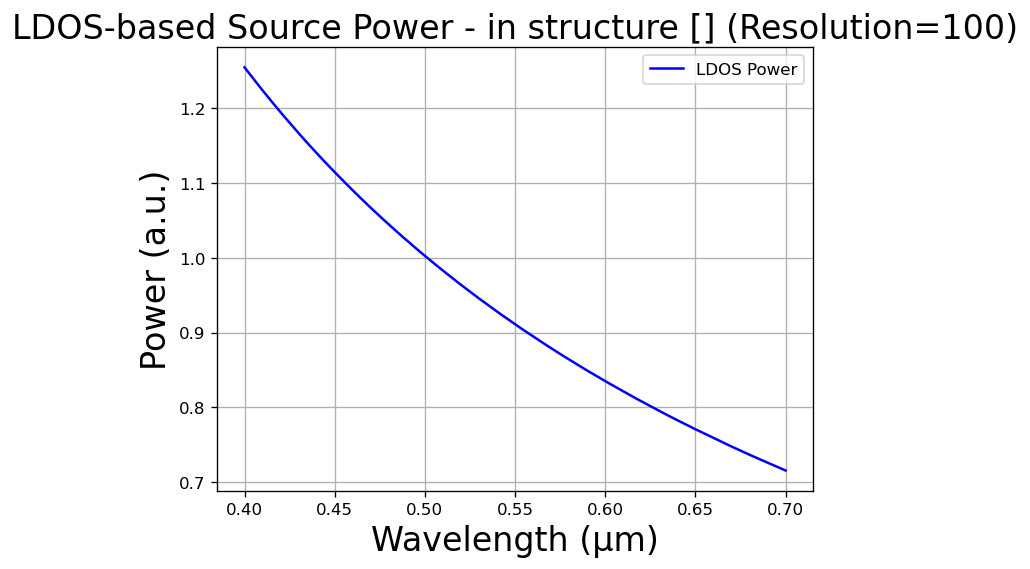

In [153]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import csv

sim.init_sim()

# === 설정 ===
resolution = 100  # ★ 함수 인자였던 것을 변수로 설정
cell_size = mp.Vector3(5, 5, 0)
fcen = 1.75
df = 3.3
nfreq = 300

field_component = mp.Ex

lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_max
fmax = 1 / lambda_min
fcen_dft = 0.5 * (fmin + fmax)
df_dft = fmax - fmin

# 소스 설정
source_center = mp.Vector3(0, 0, 0)
sources = [
    mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=field_component,
        center=source_center,
        size=mp.Vector3(0, 0)
    )
]

sio2 =  mp.Medium(epsilon = 1,   E_susceptibilities = suscept_sio2, valid_freq_range=freq_sio2) # SiO2 ,
andp =  mp.Medium(epsilon = 1,   E_susceptibilities = suscept_andp, valid_freq_range=freq_andp) # aNDP ,
Al  =   mp.Medium(epsilon = 1,     E_susceptibilities = suscept_al, valid_freq_range=freq_al)

Glass = sio2
aNDP = andp
Cathode = Al

# Cathode = mp.perfect_electric_conductor,
CoverLayer_index = 1.9
ITO_m_index = 1.8
Alq3_index = 1.68

CoverLayer = mp.Medium(epsilon=CoverLayer_index**2) # SiN ,
ITO_m = mp.Medium(epsilon=ITO_m_index**2) 
Alq3 = mp.Medium(index = Alq3_index) 
Air = mp.Medium(index=1.0) # 공기,

Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)
# cell_size = mp.Vector3(31, 2, 0)

geometry_fitting = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(mp.inf, Cathode_layer, 1),
            material=Cathode
        ),
        # Alq3
        mp.Block(
            center=Alq3_center,
            size=mp.Vector3(mp.inf, Alq3_layer, 1),
            material=Alq3
        ),
        # aNDP
        mp.Block(
            center=aNDP_center,
            size=mp.Vector3(mp.inf, aNDP_layer, 1),
            material=aNDP
        ),
        # ITO
        mp.Block(
            center=ITO_center,
            size=mp.Vector3(mp.inf, ITO_layer, 1),
            material=ITO_m
        ),
        # Cover layer
        mp.Block(
            center=Cover_center,
            size=mp.Vector3(mp.inf, Cover_layer, 1),
            material=CoverLayer
        ),
        # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        mp.Block(
            center=Glass_center,
            size=mp.Vector3(mp.inf, Glass_layer, 1),
            material=Glass
        )
]

# PML 설정
pml_layers = [mp.PML(1.5)]

# === 시뮬레이션 설정 === #
sim_fitting_st = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry_fitting[1:2],
    default_material=Alq3,
    sources=sources,
    resolution=resolution,
    eps_averaging=True,
    extra_materials=[Cathode, aNDP, Glass]
)

# === LDOS 객체 생성 ===
freqs = np.linspace(fcen_dft - df_dft/2, fcen_dft + df_dft/2, nfreq)
ldos_obj = mp.Ldos(freqs)

decay_condition = mp.stop_when_fields_decayed(
    c=mp.Ex,                          # 모니터할 전기장 컴포넌트
    pt=mp.Vector3(0, 0, 0),           # 모니터 위치
    decay_by=1e-5,                    # auto shutoff min
    dt=100,                           # down sample time
)

# === 시뮬레이션 실행 ===
sim_fitting_st.run(
    mp.dft_ldos(ldos=ldos_obj),
    until = 50
)

# === 결과 얻기 ===
ldos_power_str = np.array(sim_fitting_st.ldos_data)  # (W) 단위 power
flux_freqs = np.array(mp.get_ldos_freqs(ldos_obj))  # (1/μm) 단위 주파수
wavelengths = 1 / flux_freqs  # (μm) 단위 파장

# === CSV 저장 ===
csv_filename = f"ldos_sourcepower_res{resolution} - structure.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Wavelength (μm)", "LDOS Power (a.u.)"])
    for wl, power in zip(wavelengths, ldos_power):
        writer.writerow([wl, power])

print(f"CSV 파일 저장 완료: {csv_filename}")

# === 플롯 저장 ===
plt.figure(dpi=120)
plt.plot(wavelengths, ldos_power_str, label="LDOS Power", color='blue')
plt.xlabel("Wavelength (μm)", fontsize = 20)
plt.ylabel("Power (a.u.)", fontsize = 20)
plt.title(f"LDOS-based Source Power - in structure [] (Resolution={resolution})", fontsize = 20)
plt.grid(True)
plt.legend()


     block, center = (0,-0.67,0)
          size (1e+20,0.06,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)


<Axes: xlabel='X', ylabel='Y'>

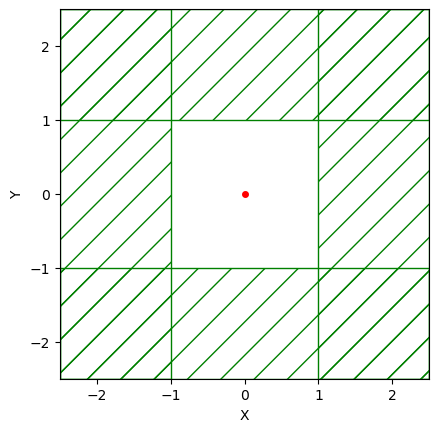

In [154]:
sim_fitting_st.plot2D()


In [130]:
# lumerical data import
import numpy as np
from pathlib import Path

csv_path_decaybox = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/One layer check/Onelayer/alq3.txt")
csv_path_decay = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/decayrate.txt")

# CSV 파일 불러오기
csv_decaybox = np.genfromtxt(csv_path_decaybox, delimiter=",", )
csv_decay = np.genfromtxt(csv_path_decay, delimiter=",", skip_header=1)

decaybox_data = csv_decaybox[:, 1]
decay_data = csv_decay[:, 1]

In [88]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/al100.txt")

# CSV 파일 불러오기
lumerical_data = np.genfromtxt(csv_path, delimiter=",")

lumerical = lumerical_data[:, 1]

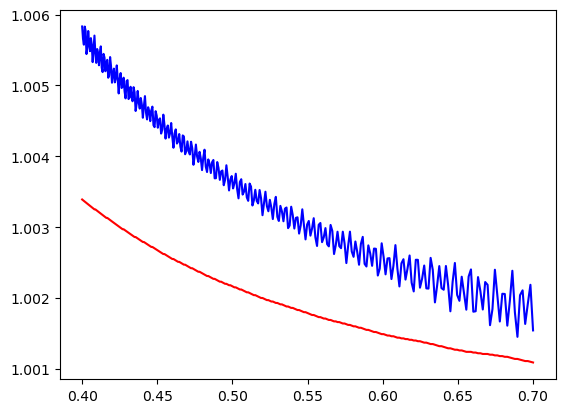

In [158]:
norm = ldos_power_str**2 / ldos_power**2 
plt.plot(wavelengths, norm, label="LDOS Power", color='blue')
plt.plot(wavelengths, decaybox_data, label="Lumerical", color='red')
plt.show()

In [ ]:
plot_filename = f"ldos_sourcepower_res{resolution} - in structure.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.close()

print(f"플롯 이미지 저장 완료: {plot_filename}")


플롯 이미지 저장 완료: ldos_sourcepower_res100 - in structure.png
